In [4]:
import os
import random

data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
cls = [os.path.join(data_path, x) for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
cls

['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess',
 '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']

In [5]:
cls_files = {}

for x in cls:
    if x not in cls_files:
        cls_files[x] = [f for f in os.listdir(x) if os.path.isfile(os.path.join(x, f))]
        
cls_files

{'/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog': ['00000349.png',
  '00000355.jpg',
  '00000162.jpg',
  '00000417.jpg',
  '00000274.jpg',
  '00000315.jpg',
  '00000348.jpg',
  '00000425.jpg',
  '00000358.jpg',
  '00000220.jpg',
  '00000312.jpg',
  '00000322.jpg',
  '00000341.jpg',
  '00000295.jpg',
  '00000361.jpg',
  '00000223.jpg',
  '00000180.jpg',
  '00000414.jpg',
  '00000310.png',
  '00000264.jpg',
  '00000298.jpg',
  '00000158.jpg',
  '00000294.jpg',
  '00000174.jpg',
  '00000186.png',
  '00000300.jpg',
  '00000351.png',
  '00000145.jpg',
  '00000285.jpg',
  '00000183.jpg',
  '00000352.png',
  '00000266.jpg',
  '00000235.jpg',
  '00000154.jpg',
  '00000290.png',
  '00000168.jpg',
  '00000277.jpg',
  '00000230.jpg',
  '00000225.jpg',
  '00000286.jpg',
  '00000289.jpg',
  '00000320.jpg',
  '00000150.jpg',
  '00000215.jpg',
  '00000379.png',
  '00000214.jpg',
  '00000179.jpg',
  '00000334.jpg',
  '00000369.png',
  '00000236.JPG',
  '00000403.jpg',
  '00000354.jpg',
  '000002

In [6]:
import random
import copy
import shutil

cls_val = {}
# 0.8, 0.2 비율로 기존의 TRAIN 셋을 나눠봅시다.
for x in cls:
    n_train_data = int(len(cls_files[x]) * 0.8) # train 비율 0.8
    n_val_data = len(cls_files[x]) - n_train_data # validation 비율 0.2
    print(len(cls_files[x]), n_train_data, n_val_data)
    train_data = random.sample(cls_files[x], n_train_data)
    val_data = copy.deepcopy(cls_files[x]) 
    
    for y in train_data: # TRAIN 폴더에서 VAL 폴더로 옮겨줄 데이터만 남기기
        val_data.remove(y)
        
    print(len(cls_files[x]), len(train_data), len(val_data))
    
    # 현재 클래스 디렉토리 생성
    x_cls = os.path.join('/aiffel/aiffel/model-fit/data/DATASET/VAL', x.split('/')[-1])
    os.makedirs(x_cls, exist_ok=True)
    for y in val_data:
        shutil.move(os.path.join(x, y), os.path.join(x_cls, y))
#         print(os.path.join(x, y), os.path.join(x_cls, y))

178 142 36
178 142 36
126 100 26
126 100 26
212 169 43
212 169 43
144 115 29
144 115 29
201 160 41
201 160 41


# 데이터 가져오기
Kaggle의 '[Yoga Poses Dataset](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset?resource=download&select=DATASET)': 5개의 요가 동작과 그에 따른 이미지들

In [1]:
!pip3 install tensorflow-estimator==2.6.0

     |████████████████████████████████| 462 kB 6.2 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.


In [2]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)

def show_batch(image_batch, label_batch, class_names):
    '''
    데이터를 시각화해주는 함수
    '''
    size = len(image_batch)
    sub_size = size
    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.rc('font', size=10)
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        print(plt.title(class_names[label_batch[n]==True][0].title()))
        plt.title(label_batch[n].numpy().decode('utf-8'))
        plt.imshow(image_batch[n])
    plt.show()
    
def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment
/tmp/ipykernel_31/3003507048.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(plt.title(class_names[label_batch[n]==True][0].title()))


IndexError: too many indices for array: array is 1-dimensional, but 5 were indexed

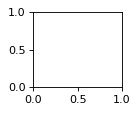

In [7]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN' 
train_dataset = load_data(data_path, batch_size=6)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

In [8]:
# 뭔가 망가진 파일이 있을 것 같은 느낌적인 느낌느낌이 듭니다. Pillow의 verify로 한 번 체크해봅시다.
import glob
from PIL import Image

data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
extensions = ['.jpg', '.png', '.jpeg']

for i, img_path in enumerate(glob.glob(os.path.join(data_path, '*/*'))):
    try:
        img = Image.open(img_path)
        img.verify()
        print('Valid image')
    except Exception:
        print('Invalid image')

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Valid image
Vali

분명 문제가 있는데.. 아주 멀쩡하다는 듯이 모두 Valid image네요.
다른 방식으로 체크해보겠습니다. JPEG 이미지를 디코딩해서 오류가 나는 파일만 모으는 것입니다.
그 파일들은 삭제되어야하겠지요. 아래의 코드를 이용할 것입니다. [이곳](https://github.com/tensorflow/tensorflow/issues/7434#issuecomment-748435673)을 참고하였습니다.

In [9]:
from struct import unpack
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in glob.glob(os.path.join(data_path, '*/*')):
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)

print(bads)

[]


In [10]:
# 다행히도 두 개의 파일이 걸렸습니다. (파일이 2개가 나오지 않는다면 기존의 데이터를 삭제하고 데이터를 다운로드한 후 처음부터 코드를 다시 실행시켜 주세요. 문제가 있는 파일이 1개 이하가 나온다면 학습할 때 오류가 날 수 있습니다. )
# 아래의 코드를 이용해 두 파일을 모두 지워주겠습니다.
for bad in bads:
    os.remove(bad)

In [11]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['/aiffel/aiffel/model-fit/data/DATASET/TRAIN/downdog', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/tree', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/plank', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/goddess', '/aiffel/aiffel/model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment


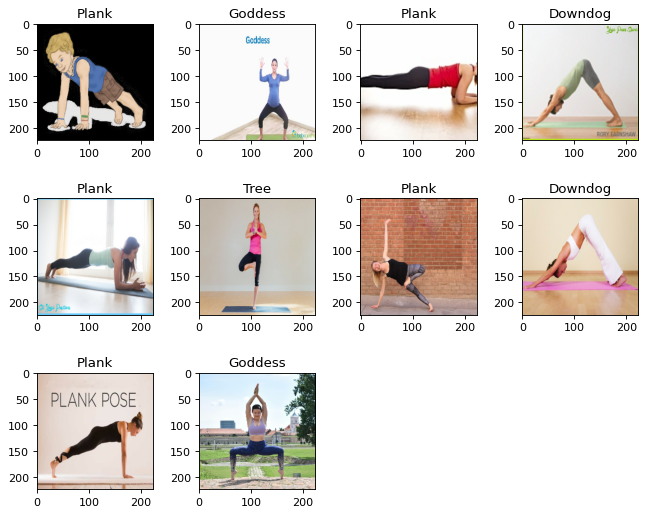

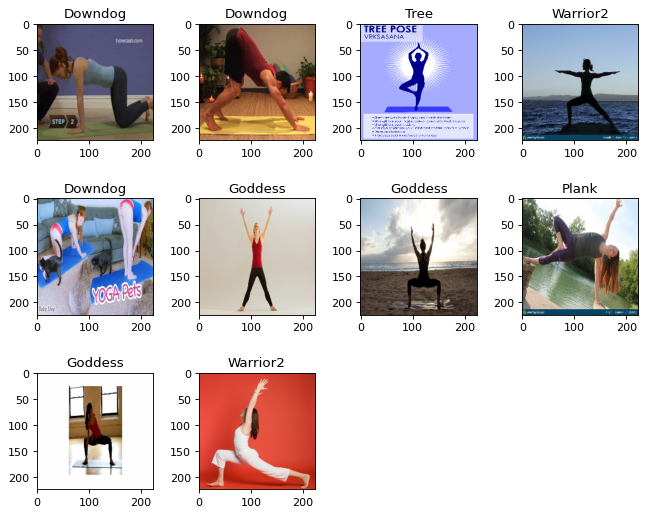

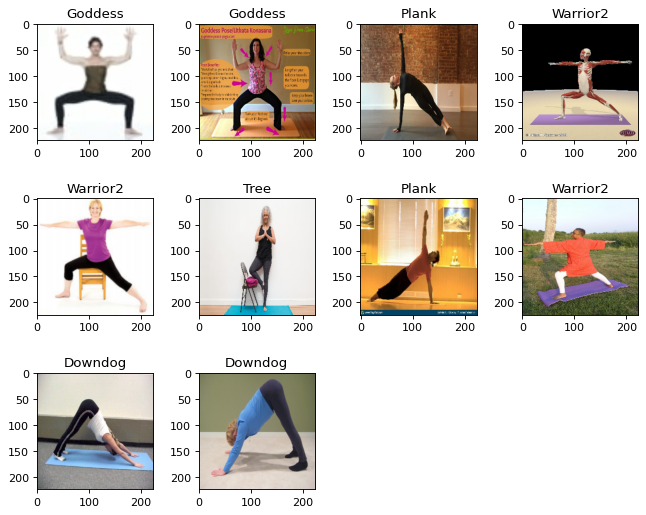

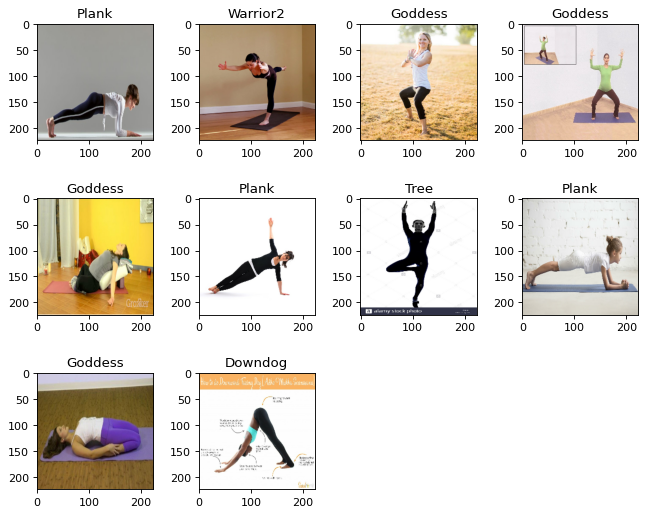

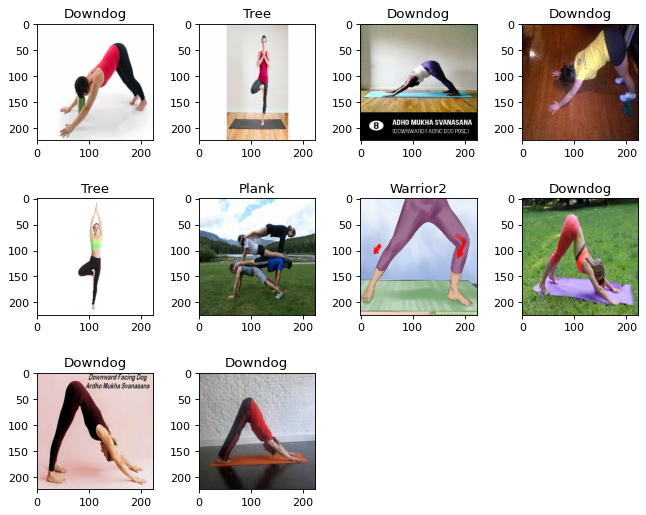

In [12]:
data_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
train_dataset = load_data(data_path, batch_size=10)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

# 모델 만들기
우리가 사용할 EfficientNet은 2019년 ICML에서 나온 논문인 [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)에서 제안하는 모델입니다.

2019년 당시에는 neural network의 depth를 더 깊게, channel 개수를 더 많이, input image size를 더 크게 만드는 방식의 딥러닝 모델이 많이 제안되었습니다. 하지만 한정된 자원으로는 사이즈가 거대한 만든 모델을 마냥 학습시키기는 어렵기 때문에, 이 논문에서는 AutoML을 이용하여 depth, channel, resolution(input image size)의 최적의 조합을 찾아내려고 하였습니다.

[케라스가 제공하는 EfficientNet](https://keras.io/api/applications/efficientnet/)을 가져와서 사용할 것입니다

In [13]:
from tensorflow.keras.applications import EfficientNetB0

class YogaPose(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=5, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = YogaPose(num_classes=5, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

16719872/16705208 [==============================] - 0s 0us/step
Model: "yoga_pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  6405      
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
_________________________________________________________________
None


# 모델 학습
우리는 이제 데이터도 있고 모델도 가지고 있습니다. 이제 학습만 하면 됩니다.
[Tensorflow docs](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch?hl=ko)를 참고하여 트레이너를 만들어봅시다.

In [ ]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
    def train(self, train_dataset, train_metric):
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

In [ ]:
epoch = 1
batch = 5
model = YogaPose(num_classes=5)
dataset = load_data(data_path=data_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer)

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)

## Train loop에 기능 추가하기
- 주의할 사항은 이전에 만든 코드에 여러가지를 덧붙여서 수정하는 것이므로 조각 코드가 주로 나올 예정입니다.
- 이전 코드의 어느 부분이 바뀌고 있는지 생각하면서 읽어가는 것이 좋습니다.

### 1. Progbar 추가하기
Progbar란 Progression Bar의 줄임말로, 학습이 얼마나 진행되었는지 바 형태로 보여주는 것입니다.

이전 Trainer의 train() 함수는 train_dataset, train_metric 단 두 개만을 인자로 받았습니다. 그러나 이제는 각 step 별로 Progbar를 찍어주기 위해 steps_per_epoch라는 인자를 추가해줄 것입니다.

여기서 step이란 batch 1개의 loss를 계산하고 gradient를 한 번 업데이트하는 것을 말합니다. 그 step은 어떻게 구할 수 있을까요?
전체 학습 데이터 사이즈를 TRAIN_SIZE라고 했을 때, 그걸 batch 사이즈로 나눈 것이 step 수가 되겠죠?


코드로 바꾼다면 아래의 lambda 함수로 compute_steps_per_epoch을 계산할 수 있을 것입니다

```
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
```

위 코드에서 우리가 아직 구해놓지 않은 값이 있습니다. 바로 TRAIN_SIZE 입니다.
그래서 기존의 load_data에서 데이터를 가져올 때 TRAIN_SIZE를 함께 계산하여 가져오게 할 것입니다. 바로 이렇게 말이죠!


```
train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
```

그러기 위해선 load_data 함수내에서 TRAIN_SIZE를 계산하도록 하여야합니다. 아래의 `load_data` 함수가 우리의 새로운 함수입니다. `tf.data.experimental.cardinality(list_ds).numpy()`을 이용해 DATASET_SIZE를 계산해서 반환해주고, img_shape를 함수의 파라미터로 넣어서 EfficientB0 말고도 다른 input image resolution을 갖는 모델들을 사용할 수 있게 바꿔주었습니다.

In [14]:
def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

이제 step 사이즈도 알았으니 step마다 진행 사항을 찍어줄 수 있을 것 같습니다!

방금 전 step은 batch 1개의 loss를 계산하고 gradient를 한 번 업데이트하는 것이라고 말했습니다. 그렇다면 우리가 업데이트시켜야 할 코드는 Trainer 부분이 될 것입니다.

진행 사항을 찍기 위해 from tensorflow.keras.utils import Progbar를 사용해보겠습니다.

우리가 원하는 Progbar의 전체 길이는 steps_per_epoch(이전에 구한 DATA_SIZE) x batch가 될 것입니다. 1 step마다 1 batch를 사용하게 되니까요.

## 2. Validation 데이터 추가하기
우리는 지금까지 train 데이터로만 진행을 해왔습니다. 하지만 운좋게도 validation 데이터가 있는 상황도 있을 것입니다. validation 데이터 추가를 했다고 해서 크게 코드에 차이가 있지 않습니다. 그래서 빠르게 validation 데이터를 추가해보도록 하겠습니다.

저는 validation 데이터가 따로 있다고 가정하고 만들었습니다.
그렇다는 건 train_path, val_path가 모두 존재한다는 뜻이겠죠! 단순히 load_data를 두 번 해주는 것에 지나치지 않습니다. 코드는 아래와 같습니다.

저는 validation 데이터가 따로 있다고 가정하고 만들었습니다.
그렇다는 건 train_path, val_path가 모두 존재한다는 뜻이겠죠! 단순히 load_data를 두 번 해주는 것에 지나치지 않습니다. 코드는 아래와 같습니다.

```
train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)
```

하지만 이 데이터를 train step에 넣어주려면 어떻게 해야 될까요? 당연히 Trainer 클래스의 train 함수에 arguments를 늘려줘야겠죠. validation을 위한 Progbar 역시 만들어주도록 해봅시다.

오! 슬슬 복잡해지는 것처럼 보입니다. 그럴 땐 튜토리얼을 읽지 않고 github 클론이나 받아서 코드나 돌려볼까 하는 마음이 생기죠. 😣

```
for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
    logits = model(x_batch_val, training=False)
    val_loss = self.loss_fn(y_batch_val, logits)
    
    # Update val metrics
    val_acc = self.compute_acc(logits, y_batch_val)
    values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]

progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
```

In [15]:
'''
dataset.py의 코드입니다! 
'''
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()

def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    print(class_names)
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [16]:
import math

train_path = '/aiffel/aiffel/model-fit/data/DATASET/TRAIN'
val_path = '/aiffel/aiffel/model-fit/data/DATASET/VAL'
batch_size = 32

train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

['downdog', 'tree', 'plank', 'goddess', 'warrior2']
['downdog', 'tree', 'plank', 'goddess', 'warrior2']


In [17]:
# train, val 데이터 셋 모두 (224, 224, 3) 사이즈의 input과 5개의 label에 대하여 true false로 이루어진 GT가 들어가있는지 확인합니다
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>)

In [18]:
from tensorflow.keras.utils import Progbar

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [19]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/3


Corrupt JPEG data: premature end of data segment


27/27 [==============================] - 69s 281ms/step - train_loss: 1.7055 - train_acc: 0.5625


Improper call to JPEG library in state 203


InvalidArgumentError: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]] [Op:IteratorGetNext]

Corrupt JPEG data: premature end of data segment


## 3. 모델 저장하기
이제 학습과 관련하여 몇 가지 처리를 해놓았으니, 학습된 모델을 저장해보도록 합시다. 기쁘게도 tensorflow에는 `tf.train.Checkpoint`라는 것이 있습니다. 모델을 저장해주는 아주 친절한 친구입니다.

사용법은 아주 간단합니다. 쓰려고 미리 준비해뒀던 optimizer와 model을 인자로 넣어주고 checkpoint를 만든 뒤, 그 checkpoint를 checkpoint manager로 만들면 됩니다. 이때 directory에는 모델이 저장될 directory를 입력하고, max_to_keep에는 최대로 저장할 모델의 개수를 지정해줍니다.

```
model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory=".", max_to_keep=5)
```

그다음엔 역시 Trainer 클래스의 `train` 함수에 manager를(`tf.train.CheckpointManager` 객체) 보내 1 epoch이 끝날 때마다 manager.save()를 넣어 모델을 저장해주면 됩니다. 하지만 tensorflow와 keras에는 callback이라는 것이 있죠. 그 callback 중엔 학습한 모델 중 가장 좋은 모델만 저장해주는 애가 있습니다. 우리도 그것과 비스무리한 걸 구현해볼까 합니다.

가장 좋은 모델을 저장하려면 임의의 loss인 best_loss를 두고, 매번 생기는 val_loss가 그것보다 낮을 때만 모델을 저장하게 하면 됩니다. loss는 0에 가까워질수록 좋으니까요.

loss가 아닌 acc로 해도 무방합니다. 단 `best_loss`가 아닌 `best_acc`일 경우에는 이전의 acc보다 현재 acc가 더 높을 때 저장을 해야한다는 것을 주의해야합니다.

In [20]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step, checkpoint_manager):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        best_loss = 100
        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
            
            if val_loss < best_loss:
                best_loss = val_loss
                print("\nSave better model")
                print(checkpoint_manager.save())

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory="aiffel/model-fit/checkpoint", max_to_keep=5) #체크포인트 저장위치 자유롭게 변경

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric,
            checkpoint_manager=manager)


Epoch 1/3
27/27 [==============================] - 19s 401ms/step - train_loss: 2.0596 - train_acc: 0.4062 - val_loss: 1.6734 - val_acc: 0.0625

Save better model
aiffel/model-fit/checkpoint/ckpt-1

Epoch 2/3
27/27 [==============================] - 10s 285ms/step - train_loss: 1.6437 - train_acc: 0.5938
